In [1]:
import ConfigParser
from datetime import datetime
import os
import sys
import time

import numpy as np
import pandas as pd
from sklearn import preprocessing, svm

# Extend sys.path for relative imports
sys.path.extend(["/Users/daddy30000/dev/ucb_smartcities_all/sandbox/neverforgit/src/main/python/CanonicalSmartBay/"])
import utils.counts as counts

In [2]:
ts_dir = "/Users/daddy30000/dev/data/PeMS/SmartBay/time_series/2015_all/"
# ts_dir = "/Users/daddy30000/dev/data/PeMS/SmartBay/time_series/big_test/"
config_path = "/Users/daddy30000/dev/ucb_smartcities_all/sandbox/neverforgit/src/main/python/CanonicalSmartBay/config/config_test_filters.ini"
results_path = "/Users/daddy30000/dev/data/PeMS/SmartBay/scenarios/summer_2015/filtering_weekdays/filtering_results.txt"

In [3]:
##
# Load values from config file
##
conf = ConfigParser.ConfigParser()
conf.read(config_path)

# Paths
meta_path = conf.get('Paths', 'meta_path')
stat_link_map_path = conf.get('Paths', 'stat_link_map_path')
ts_dir = conf.get('Paths', 'ts_dir')  # Path to station Time Series
out_cleaned_path = conf.get('Paths', 'out_cleaned_path')  # Where to write the results of filtering
out_removed_path = conf.get('Paths', 'out_removed_path')  # Where to write the results of filtering
out_log_path = conf.get('Paths', 'out_log_path')  # Where to write the results of filtering
poly_path = conf.get('Paths', 'poly_path')  # Where to write the results of filtering

# Parameters
start_date = datetime.strptime(conf.get('Params', 'start_date'), '%Y/%m/%d')
end_date = datetime.strptime(conf.get('Params', 'end_date'), '%Y/%m/%d')
weekdays = [int(d) for d in [s.strip() for s in conf.get('Params', 'weekdays').split(',')]]
counts_year = conf.get('Params', 'counts_year')

date_list = counts.date_string_list(start_date, end_date, weekdays)


In [4]:
##
# Load the list of station_IDs
# Remove the stations that triggered the Date Range, Link Mapping, Missing Data, and Boundary Buffer filters.
##

# Get the stations to remove
results = pd.read_csv(results_path, header=None)
results.columns = ['ID', 'Reason']
triggers = [" ['date_range']", " ['link_mapping']", " ['missing_data']", " ['boundary_buffer']"]
print 'Number of stats to remove: ' + str(np.sum(results.Reason.isin(triggers)))
remove = [s.strip("'") for s in results[results.Reason.isin(triggers).values]['ID'].values]

# Build and clean the stat_ID list
os.chdir(ts_dir)
stations = [n for n in os.listdir('.') if n.isdigit() and n not in remove]  #


Number of stats to remove: 725


In [22]:
## 
# Iterate through all the stations and calculate the distances
##
dists_dict = {}
clf = svm.OneClassSVM()

t0 = time.time()
for i, stat in enumerate(stations):
    if not i%10:
        print "Processing station %s" % (stat)
    # Write the output every 100 iterations
    if not i%100:
        print 'writing output now'
        dists_df = pd.DataFrame.from_dict(dists_dict)
        dists_df.to_csv("/Users/daddy30000/dev/data/PeMS/SmartBay/test/OneClassSVM_dists_all.csv", index=False)
    # Load the time series df and process
    ts_df = pd.read_csv('./%s/time_series.csv' % stat, index_col='Timestamp')
    ts_df['date'] = [d[0:10] for d in ts_df.index]
    ts_df['hour'] = [d[-8:-6] for d in ts_df.index]
    vol_5min = ts_df[ts_df['date'].isin(date_list)][['Total_Flow', 'hour', 'date']] # all 5-min observations on desired dates
    vol_5min.index = pd.to_datetime(vol_5min.index)
    ##
    # Create the feature matrix, X
    ##
    
    # Group by dates
    groups = vol_5min.groupby(['date'])
    n = len(groups.groups.keys())  # number of unique groups
    X = np.empty((n, 24))  # Feature vector n x p
    for i, (dt, g) in enumerate(groups):
        # dt is a date string, g is dataframe
        X[i,:] = g.resample('1h').sum().values.flatten()  # Rollup the 5-minute counts to 1-hr
    # Check for NaN 
    if np.isnan(X).any() or 0 in X.shape:
        continue # skip it if has NaN values
    # Scale and center the data
    try:
        preprocessing.scale(X, axis=1, copy=False)
    except ValueError:
        continue
    # Train and recorded distances
    clf.fit(X)
    dists_dict[stat] = clf.decision_function(X).flatten()                                 
t1 = time.time()
print "Time to test %d stations: %d [sec]" % (len(stations), t1 - t0)


Processing station 400000
writing output now
Processing station 400017
Processing station 400040
Processing station 400057
Processing station 400078
Processing station 400095
Processing station 400109
Processing station 400124
Processing station 400143
Processing station 400158
Processing station 400178
writing output now
Processing station 400193
Processing station 400211
Processing station 400228
Processing station 400248
Processing station 400263
Processing station 400280
Processing station 400298
Processing station 400313
Processing station 400329
Processing station 400340
writing output now
Processing station 400361
Processing station 400388
Processing station 400402
Processing station 400420
Processing station 400436
Processing station 400446
Processing station 400463
Processing station 400485
Processing station 400498
Processing station 400516
writing output now
Processing station 400536
Processing station 400552
Processing station 400571
Processing station 400591
Processing sta

In [23]:
dists_df = pd.DataFrame.from_dict(dists_dict)
dists_df.to_csv("/Users/daddy30000/dev/data/PeMS/SmartBay/test/OneClassSVM_dists_all.csv", index=False)                                   

In [24]:
##
# Plot histogram
##
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

dists = dists_df.values.flatten()

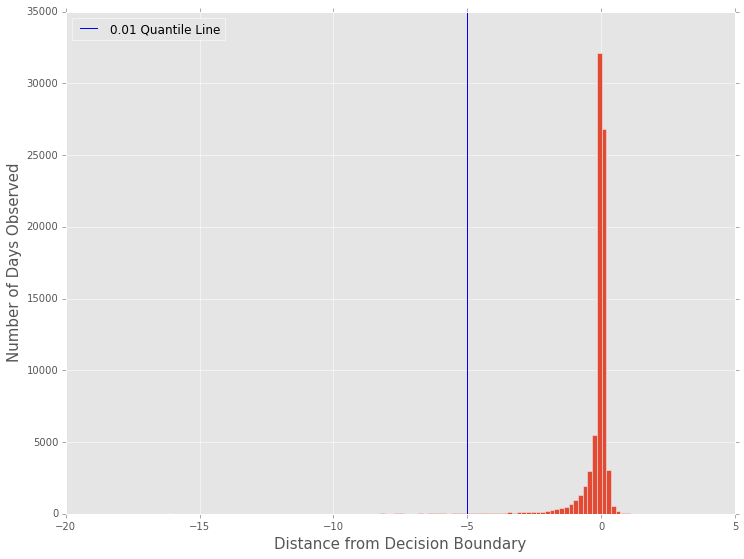

In [25]:
plt.figure(figsize=(12,9))
h = plt.hist(dists.flatten(), bins=100);
vl = plt.axvline(np.percentile(dists.flatten(), 1), label='0.01 Quantile Line')
plt.xlabel('Distance from Decision Boundary', fontsize=15)
plt.ylabel('Number of Days Observed', fontsize=15)
plt.legend(handles =[vl], loc=2, fontsize=12)

In [28]:
print '0.01 Quantile: ' + str(np.percentile(dists.flatten(), 1))

0.01 Quantile: -5.00525888355
